In [1]:
# 1. Setup

import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Paths
BASE = Path.cwd().parent if (Path.cwd().name == "notebooks") else Path.cwd()
DATA = BASE / "data"
PROC = DATA / "processed"
REPORTS = BASE / "reports"
FIGS = REPORTS / "figures"

for p in [PROC, REPORTS, FIGS]:
    p.mkdir(parents=True, exist_ok=True)

print("Directories Ready.")

Directories Ready.


In [2]:
# 2. Load Processed Data

file_path = PROC / "analysis_base_with_full_interpolation.csv"
df = pd.read_csv(file_path)
print("Loaded:", file_path)
print("Shape:", df.shape)
print("Years:", df["Year"].min(), "-", df["Year"].max(), "| Countries:", df["Country"].nunique())
df.head()

Loaded: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\analysis_base_with_full_interpolation.csv
Shape: (12449, 6)
Years: 1960 - 2018 | Countries: 211


,Country,Year,fertility,migration,urban_pop,flfp
0,Afghanistan,1960,7.282,2606.0,8.401,6.83
1,Afghanistan,1961,7.284,6109.0,8.684,6.83
2,Afghanistan,1962,7.292,7016.0,8.976,6.83
3,Afghanistan,1963,7.302,6681.0,9.276,6.83
4,Afghanistan,1964,7.304,7079.0,9.586,6.83


In [3]:
# 3. Check

na_rates = df.isna().mean().sort_values(ascending=False)
print("NaN Rates by Column:")
print((na_rates * 100).round(2))

NaN Rates by Column:
Country      0.0
Year         0.0
fertility    0.0
migration    0.0
urban_pop    0.0
flfp         0.0
dtype: float64


Correlation Matrix:
           fertility      flfp  urban_pop  migration
fertility   1.000000 -0.246047  -0.613464  -0.044062
flfp       -0.246047  1.000000  -0.025932   0.032318
urban_pop  -0.613464 -0.025932   1.000000   0.120452
migration  -0.044062  0.032318   0.120452   1.000000
Saved: c:\Users\Lenovo\Documents\GitHub\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\correlation_matrix.png


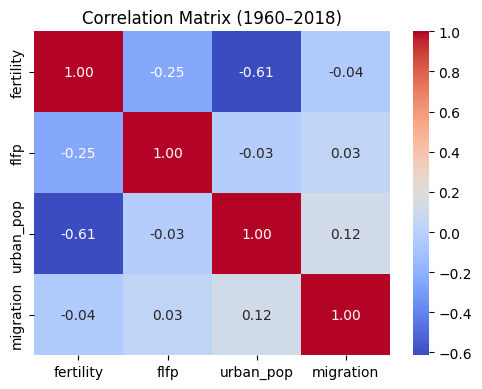

In [4]:
# 4. Correlation Analysis

cols = ["fertility", "flfp", "urban_pop", "migration"]

corr = df[cols].corr()
print("Correlation Matrix:")
print(corr)

plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix (1960–2018)")
plt.tight_layout()

# Save figure
out_path = FIGS / "correlation_matrix.png"
plt.savefig(out_path, dpi=300)
print(f"Saved: {out_path}")

plt.show()

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16632\1239809984.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g["flfp"].corr(g["urban_pop"]))


Countries with Valid Within-Corr: 202
Average Within-Country Correlation: 0.385
Median Within-Country Correlation: 0.672

Top 10 Countries by Within-Country Correlation:
                     Country  within_corr
                     Nigeria     0.993637
                   Greenland     0.992831
                  Costa Rica     0.980851
                     Uruguay     0.979603
                      Panama     0.979377
                    Honduras     0.972823
                      Brazil     0.971999
United States Virgin Islands     0.969817
                     Germany     0.961932
                     Belgium     0.960413

Bottom 10 Countries by Within-Country Correlation:
              Country  within_corr
              Austria    -0.963496
        Liechtenstein    -0.945120
               Turkey    -0.941687
      Channel Islands    -0.919821
Sao Tome and Principe    -0.914760
                China    -0.908361
               Belize    -0.845710
     Marshall Islands    -0.831923
 

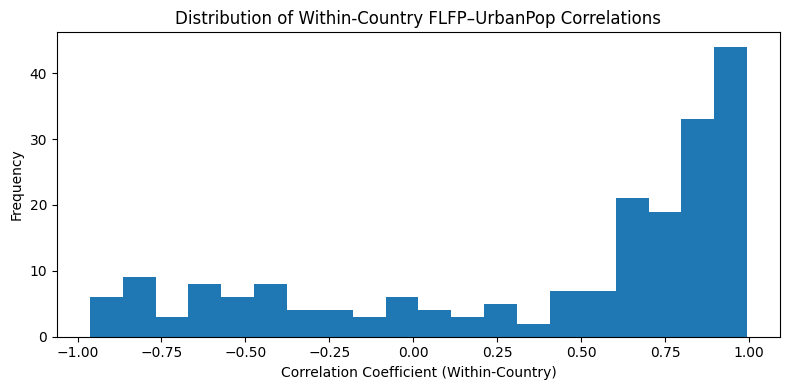

In [5]:
# 5. Within-Country Correlation Analysis

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

within_corrs = (
    df[["Country","flfp","urban_pop"]]
      .dropna(subset=["flfp","urban_pop"])
      .groupby("Country")
      .apply(lambda g: g["flfp"].corr(g["urban_pop"]))
      .rename("within_corr")
      .reset_index()
      .dropna(subset=["within_corr"])
)

# Specific Outputs
avg_corr = within_corrs["within_corr"].mean()
med_corr = within_corrs["within_corr"].median()
n_countries = len(within_corrs)
print(f"Countries with Valid Within-Corr: {n_countries}")
print(f"Average Within-Country Correlation: {avg_corr:.3f}")
print(f"Median Within-Country Correlation: {med_corr:.3f}")

# Top/Bottom 10 Countries by Within-Country Correlation
print("\nTop 10 Countries by Within-Country Correlation:")
print(within_corrs.sort_values("within_corr", ascending=False).head(10).to_string(index=False))

print("\nBottom 10 Countries by Within-Country Correlation:")
print(within_corrs.sort_values("within_corr", ascending=True).head(10).to_string(index=False))

# Histogram of Within-Country Correlations
plt.figure(figsize=(8,4))
plt.hist(within_corrs["within_corr"], bins=20)
plt.title("Distribution of Within-Country FLFP–UrbanPop Correlations")
plt.xlabel("Correlation Coefficient (Within-Country)")
plt.ylabel("Frequency")
plt.tight_layout()

# Save Figure
out_path = FIGS / "within_country_correlation_distribution.png"
plt.savefig(out_path, dpi=300)
print(f"Saved: {out_path}")

plt.show()

Interpretation (Summary of Correlations)

1. Global (Pooled) Correlations

Fertility and Urban Population show a strong negative correlation.
→ Countries with higher urbanization tend to have lower fertility rates.

Fertility and Female Labour Force Participation are moderately negative,
suggesting that as more women join the workforce, fertility declines.

Migration has no clear global relationship with the other variables.

2. Within-Country Correlations (Over Time)

Within countries, the link between Fertility and Urbanization becomes even stronger and negative.
→ As nations urbanize over time, fertility tends to fall.

Fertility and Female Labour Participation remain negatively related.

Urbanization and Female Labour Participation are positively related, showing that social and economic development often progress together.

3. Between-Country Correlations

Countries that are more urbanized and have higher female labour participation generally have lower fertility rates.

These patterns reflect long-term structural differences between developed and developing regions.

4. Summary

Overall, the data shows a consistent pattern:
urbanization and female workforce participation are both linked to declining fertility — both across and within countries — while migration plays a minimal role.